In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

## Reading Data

In [2]:
# Load .npy files using numpy's load function
X_embed_1 = np.load('../data/embeddings_1.npy')
X_embed_2 = np.load('../data/embeddings_2.npy')

# Load text files using standard Python open function
with open('../data/icd_codes_1.txt', 'r') as file:
    label_embed_1 = file.read().strip()  # Remove any leading/trailing whitespace

with open('../data/icd_codes_2.txt', 'r') as file:
    label_embed_2 = file.read().strip()  # Remove any leading/trailing whitespace

# Create DataFrames from the numpy arrays
df_embed_1 = pd.DataFrame(X_embed_1)
df_embed_2 = pd.DataFrame(X_embed_2)

# Split the labels by newline and assign to the DataFrame
df_embed_1['labels'] = label_embed_1.split('\n')
df_embed_2['labels'] = label_embed_2.split('\n')

# Concatenate the DataFrames
df = pd.concat([df_embed_1, df_embed_2], ignore_index=True)

# Split the labels by semicolon
df['labels'] = df['labels'].apply(lambda x: x.split(';'))

df.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,labels
0,-0.138629,-0.229309,-0.691909,0.174990,-0.147606,0.546933,-0.711464,0.086546,0.175574,0.150720,...,-0.066820,-0.106462,-0.180066,0.170044,-0.998879,0.622624,0.719849,-0.108738,1.254957,[H65.23]
1,1.338272,-0.123468,0.522916,-0.761171,-0.243275,0.550109,0.205095,0.596237,0.369073,-0.251638,...,-0.671389,0.732121,-0.907783,-0.572734,-0.021818,0.300998,0.386684,-0.597378,0.522281,"[G89.29, M25.562]"
2,-0.313802,-0.717166,0.303416,0.653793,-0.693514,0.032964,-0.263691,-0.205346,-0.080448,-0.094282,...,0.184446,0.368608,-0.418135,0.059209,-0.327019,0.145836,0.399618,-0.130010,-0.124595,"[R13.10, K20.90, K31.89, K25.9, K29.80]"
3,-0.617688,-0.830042,-0.126423,-0.410705,-0.054841,-0.296524,0.620169,0.229296,-0.559252,0.410969,...,0.894020,-0.192655,-0.007297,-0.450359,0.597864,0.270095,-0.072449,1.206772,0.180913,"[K20.90, R10.11, Z86.010, K57.30, Z90.49]"
4,0.740153,0.449349,0.072621,-0.370613,0.507154,-0.197308,0.175400,0.142559,-0.202709,0.360109,...,-0.199335,-0.067989,-1.119830,0.564957,-0.118936,-0.074200,0.728665,0.398697,-0.083612,"[R93.3, K29.50, R10.84, K31.89, R19.7]"


In [3]:
# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the labels
label = mlb.fit_transform(df['labels'])
data = df.drop('labels', axis=1)

# Display the first 5 binarized labels
print(label[:5])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## EDA

In [4]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
count,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000,...,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000,198982.000000
mean,0.035745,-0.294374,0.128021,-0.045989,0.135025,0.165583,0.141005,0.210744,0.044245,0.166036,...,0.135938,-0.149924,0.169551,-0.278326,-0.202134,-0.293193,-0.048600,0.195960,-0.062492,-0.260584
std,0.586197,0.544019,0.484706,0.462903,0.493444,0.543678,0.535328,0.679119,0.439765,0.593359,...,0.497618,0.550216,0.556654,0.587536,0.483765,0.528216,0.469768,0.466822,0.562808,0.471618
min,-2.740032,-3.090216,-2.013178,-2.013793,-1.914606,-2.474727,-1.891813,-2.411139,-2.246568,-2.411163,...,-2.413746,-2.338831,-2.153770,-3.441448,-2.403991,-2.658768,-2.404126,-2.063895,-2.297032,-2.417359
25%,-0.343048,-0.615425,-0.191701,-0.352066,-0.187253,-0.204832,-0.241014,-0.265104,-0.230462,-0.242301,...,-0.181736,-0.523233,-0.199534,-0.654046,-0.532304,-0.627419,-0.354956,-0.105238,-0.419187,-0.572498
50%,0.057421,-0.272910,0.128209,-0.063266,0.130576,0.162721,0.140415,0.188593,0.048892,0.155200,...,0.151579,-0.150445,0.171718,-0.272876,-0.201075,-0.280770,-0.043338,0.199977,-0.068559,-0.262996
75%,0.422088,0.061503,0.441731,0.232272,0.452494,0.529459,0.508897,0.647916,0.322835,0.579068,...,0.458366,0.203639,0.543165,0.113303,0.113599,0.058220,0.278209,0.499266,0.296908,0.050135
max,2.296288,2.658804,2.290709,2.455730,2.301424,2.424623,2.270932,2.776699,2.173027,2.674361,...,2.392430,2.417791,2.360754,2.086018,1.935782,1.869010,1.890795,2.107716,3.020952,2.200516


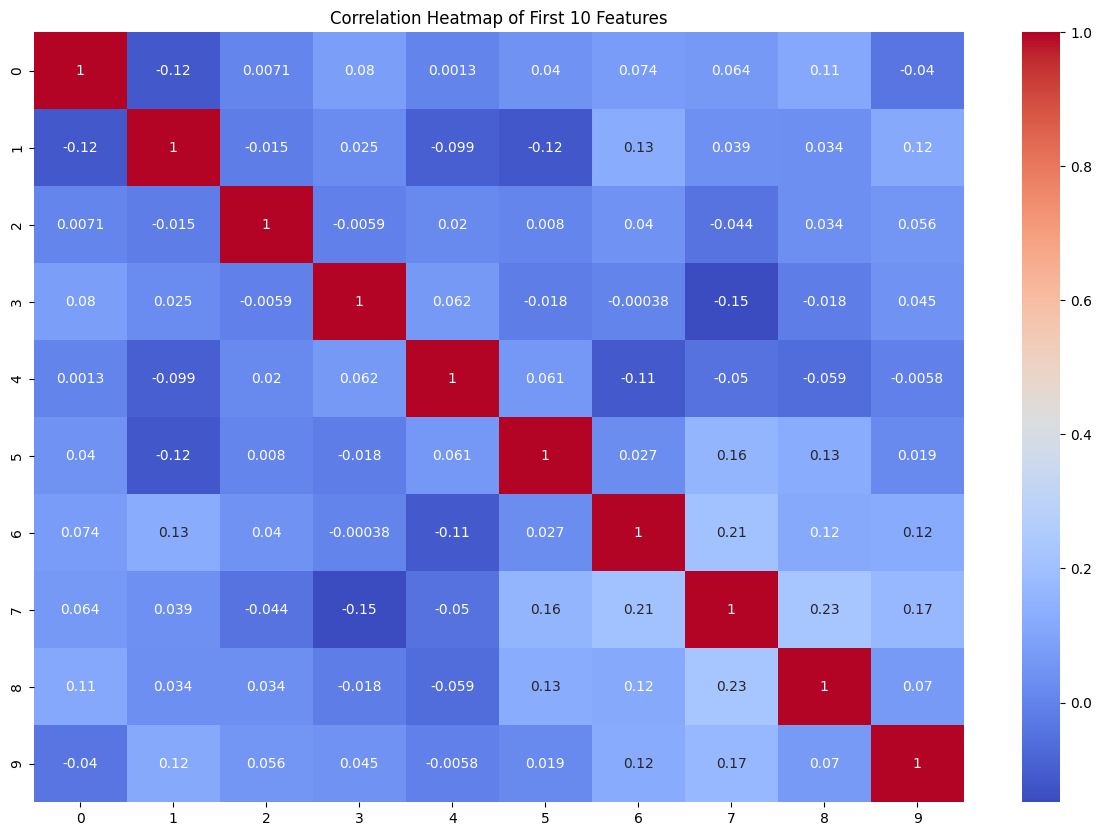

In [5]:
# Heatmap of the first 10 features
plt.figure(figsize=(15, 10))
sns.heatmap(data.iloc[:, :10].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of First 10 Features')
plt.show()

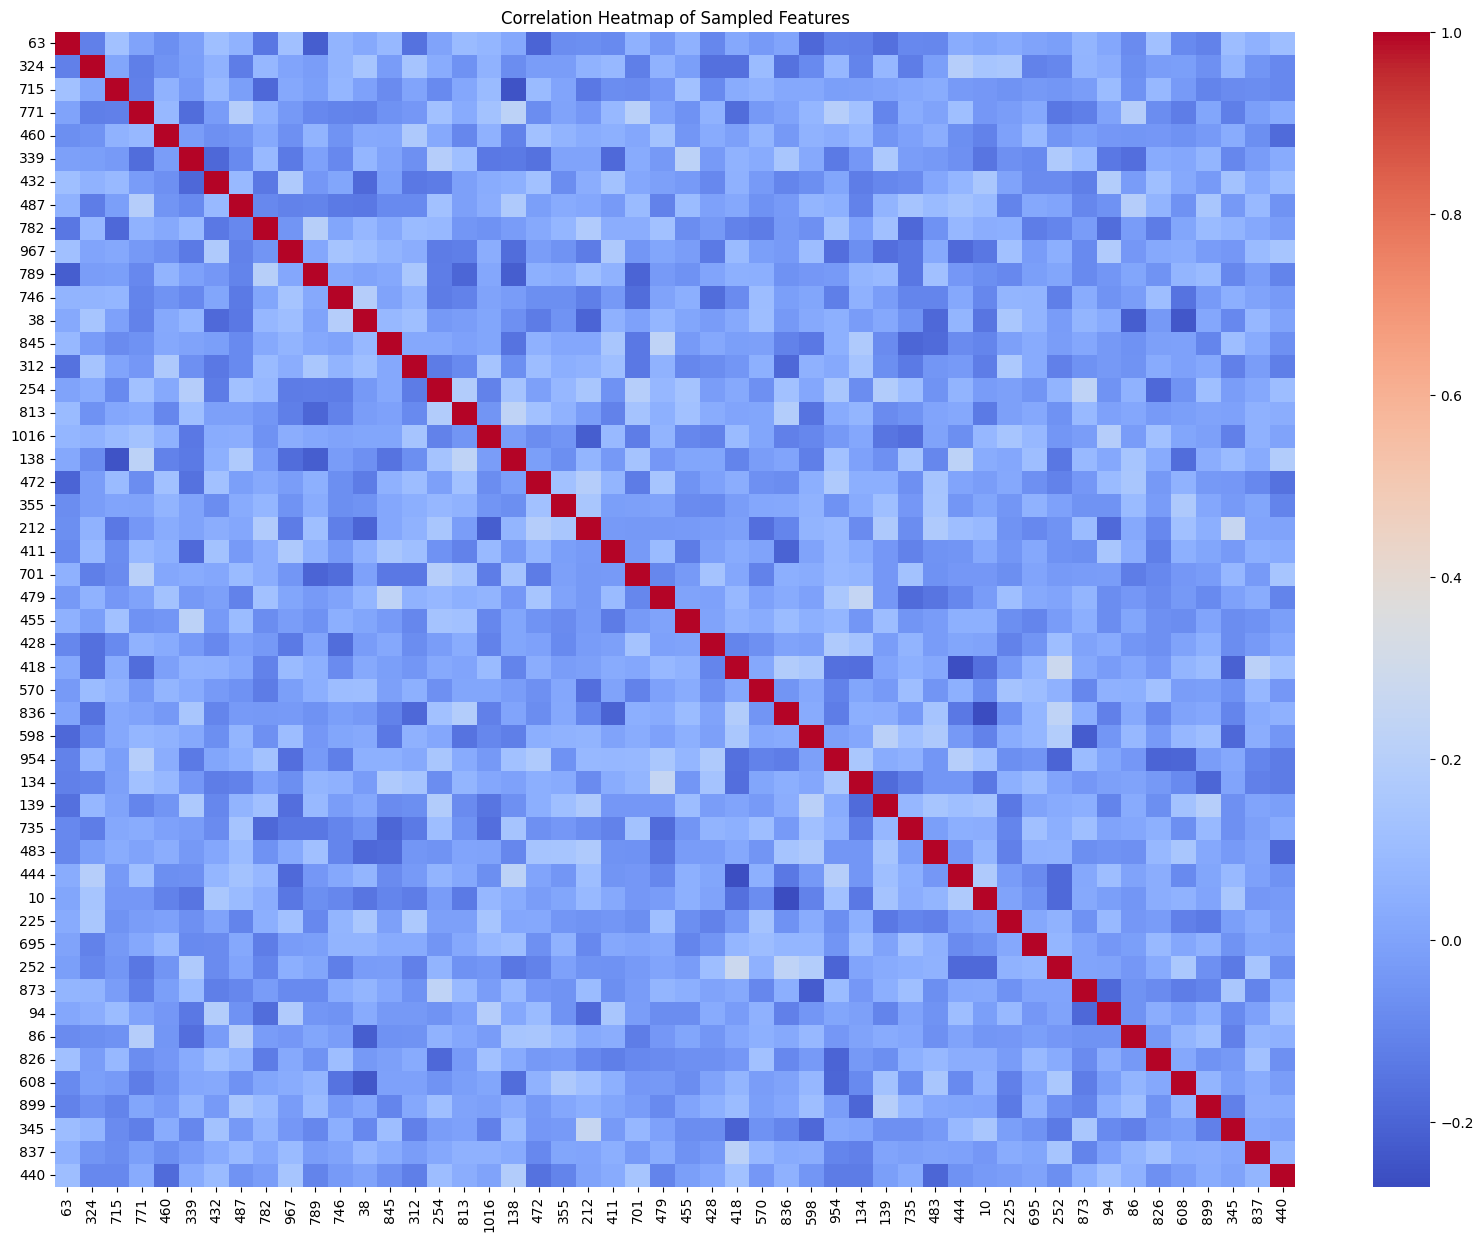

In [6]:
# Due to the large number of columns, we will sample a subset for visualization
sampled_columns = data.sample(n=50, axis=1)  # Sample 50 columns for correlation plot

# Compute the correlation matrix
corr_matrix = sampled_columns.corr()

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Sampled Features')
plt.show()

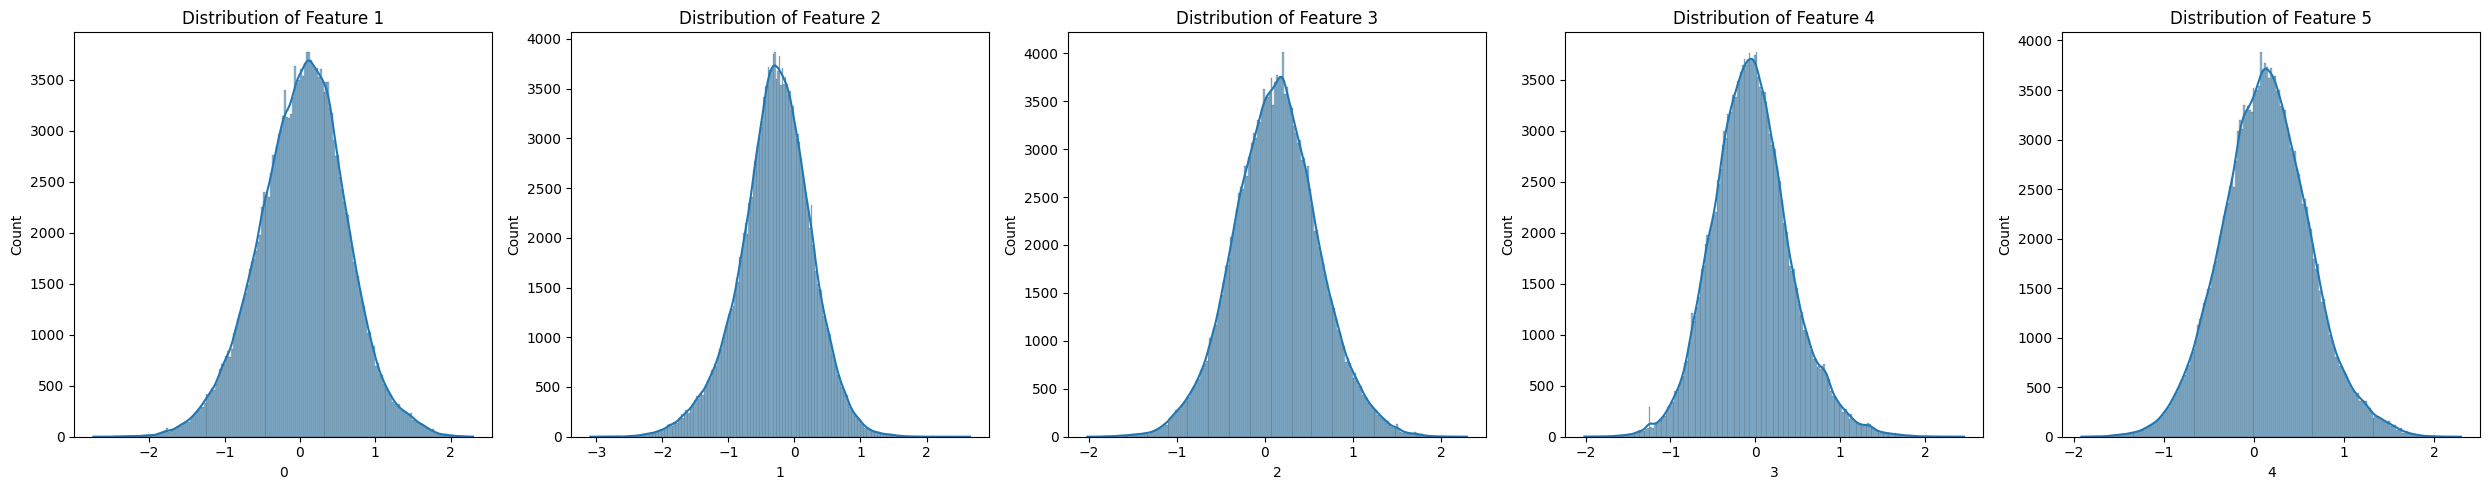

In [7]:
# Distribution of the first few features
plt.figure(figsize=(25, 5))  # Adjust the figure size for horizontal layout
for i in range(5):
    plt.subplot(1, 5, i+1)  # Change the layout to 1 row and 5 columns
    sns.histplot(data.iloc[:, i], kde=True)
    plt.title(f'Distribution of Feature {i+1}')
plt.tight_layout()
plt.show()

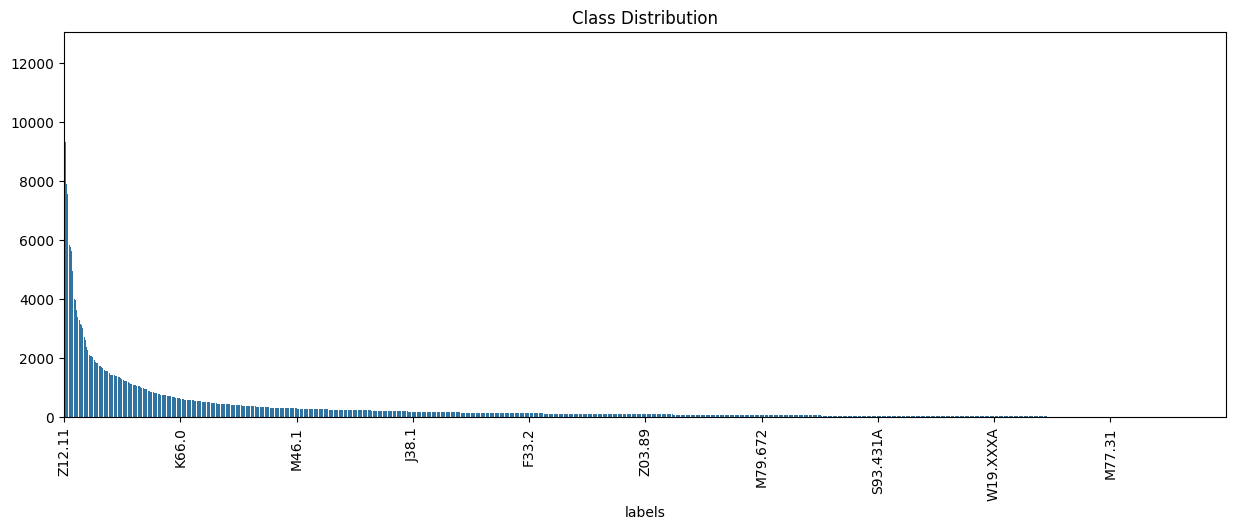

In [8]:
# Check for class imbalance
label_counts = df['labels'].explode().value_counts()

plt.figure(figsize=(15, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Class Distribution')

# Show name of every other ICD code
plt.xticks(rotation=90)
plt.xticks(ticks=range(0, len(label_counts), 140), labels=label_counts.index[::140])

plt.show()

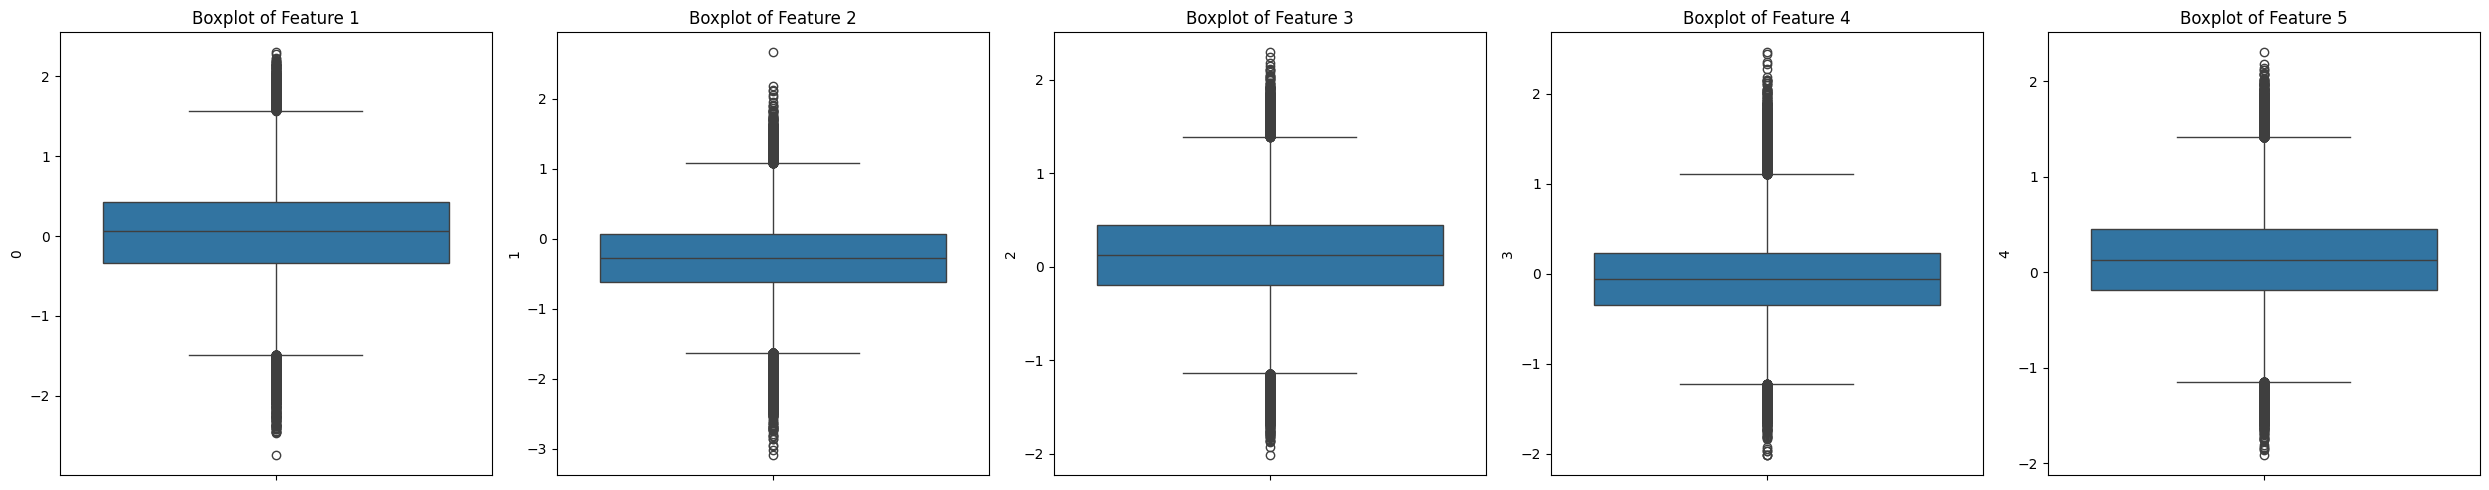

In [9]:
# Boxplot for a subset of features
plt.figure(figsize=(25, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    sns.boxplot(y=data.iloc[:, i])
    plt.title(f'Boxplot of Feature {i+1}')
plt.tight_layout()
plt.show()

## Prediction without any data engineering

In [10]:
data = np.array(data)
label = np.array(label)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=0)

In [ ]:
rf = RandomForestClassifier(random_state=0)
multi_target_rf = MultiOutputClassifier(rf, n_jobs=-1)

multi_target_rf.fit(X_train, y_train)

y_pred = multi_target_rf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=mlb.classes_))
print(f'F2 Score: {fbeta_score(y_test, y_pred, beta=2, average="samples")}')

In [ ]:
mlp = MLPClassifier(random_state=0)
multi_target_mlp = MultiOutputClassifier(mlp, n_jobs=-1)

multi_target_mlp.fit(X_train, y_train)

y_pred = multi_target_mlp.predict(X_test)

print(classification_report(y_test, y_pred, target_names=mlb.classes_))
print(f'F2 Score: {fbeta_score(y_test, y_pred, beta=2, average="samples")}')

## Data Engineering